<a href="https://colab.research.google.com/github/jingjieyuan573-bite/Composite_Distribution_analysis/blob/main/composite_distribution_data_fit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
uploaded = files.upload()  # 选择文件

Saving TSLA1.xlsx to TSLA1.xlsx


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, t
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy import stats

In [6]:
df = pd.read_excel('TSLA1.xlsx')

# 确认列名（假设第二列是收盘价，可以打印 df.head() 查看实际列名）
print("数据前5行：")
print(df.head())

# 如果收盘价列叫 "Close"，用这个名字；否则替换成实际列名
if "Close" in df.columns:
    close_prices = df["Close"]
else:
    close_prices = df.iloc[:, 1]  # 退一步保险用第二列

# ==========================================================
#                          数据清洗
# ==========================================================
# 去掉 NaN 和 非正数
close_prices = close_prices.dropna()
close_prices = close_prices[close_prices > 0]

print("\n收盘价样本（前5个）：")
print(close_prices.head())
print("最小值:", close_prices.min())
print("是否有NaN:", close_prices.isna().any())
print("是否有非正数:", (close_prices <= 0).any())

# ==========================================================
#                       计算对数收益率
# ==========================================================
returns = 100 * np.log(close_prices / close_prices.shift(1))  # 对数收益率 ×100 变百分比
returns = returns.dropna()

print("\n收益率样本（前5个）：")
print(returns.head())

# ==========================================================
#                     收益率基本统计信息
# ==========================================================
print("\n收益率基本信息：")
print(returns.describe())

skewness = stats.skew(returns)
# fisher=True 返回超额峰度（正态=0），fisher=False 返回通常意义峰度（正态=3）
kurtosis_excess = stats.kurtosis(returns)
kurtosis = stats.kurtosis(returns, fisher=False)

print("偏度：", skewness)
print("超额峰度：", kurtosis_excess)
print("通常峰度：", kurtosis)

# ==============================================

# #df = pd.DataFrame({
#    'x': log_return,

# })

# df.to_csv("log_return.csv", index=False)

数据前5行：
         date   close
0  2017-01-03  216.99
1  2017-01-04  226.99
2  2017-01-05  226.75
3  2017-01-06  229.01
4  2017-01-09  231.28

收盘价样本（前5个）：
0    216.99
1    226.99
2    226.75
3    229.01
4    231.28
Name: close, dtype: float64
最小值: 108.1
是否有NaN: False
是否有非正数: False

收益率样本（前5个）：
1    4.505469
2   -0.105787
3    0.991758
4    0.986343
5   -0.611517
Name: close, dtype: float64

收益率基本信息：
count    2083.000000
mean        0.005148
std         5.616349
min      -149.104263
25%        -1.827805
50%         0.135332
75%         2.027635
max        20.449054
Name: close, dtype: float64
偏度： -12.599125001987494
超额峰度： 308.59353149425584
通常峰度： 311.59353149425584


In [7]:
def skew_normal_pdf(x, xi, omega, alpha):
    # 标准化变量
    z = (x - xi) / omega
    # 计算标准正态分布的 PDF 和 CDF
    phi_z = norm.pdf(z)
    Phi_alpha_z = norm.cdf(alpha * z)
    # Skew-Normal 分布的 PDF
    return (2 / omega) * phi_z * Phi_alpha_z

#skew-normal 分布的 CDF
def skew_normal_cdf(x, xi, omega, alpha):
    return quad(lambda t: skew_normal_pdf(t, xi, omega, alpha), -np.inf, x)[0]

In [8]:
def skew_t_pdf(x, xi_t, omega_t, alpha_t, nu):
    # 标准化变量
    z = (x - xi_t) / omega_t
    # 计算 t 分布的 PDF
    t_pdf = t.pdf(z, df=nu)
    # 计算调整因子
    a = alpha_t * z * np.sqrt((nu + 1) / (nu + z**2))
    t_cdf = t.cdf(a, df=nu + 1)
    # Skew-t 分布的 PDF
    return (2 / omega_t) * t_pdf * t_cdf

#skew-t_CDF
def skew_t_cdf(x, xi_t, omega_t, alpha_t, nu):
    return quad(lambda t: skew_t_pdf(t, xi_t, omega_t, alpha_t, nu), -np.inf, x)[0]

In [9]:
###定义skew-normal分布的导函数


from sympy import symbols, diff, exp, sqrt, pi, erf
from sympy.stats import Normal, density, cdf

    # 定义符号变量
x, xi, omega, alpha = symbols('x xi omega alpha', real=True)
omega_pos = symbols('omega_pos', positive=True)  # omega > 0
z = (x - xi) / omega_pos

    # 定义标准正态分布 PDF (φ) 和 CDF (Φ)
phi = density(Normal('N', 0, 1))(z)
Phi = cdf(Normal('N_cdf', 0, 1))(alpha * z)

    # Skew-normal PDF
skewnorm_pdf = (2 / omega_pos) * phi * Phi

    # 计算导函数
skewnorm_derivative = diff(skewnorm_pdf, x)

from scipy.stats import norm
import numpy as np

def skewnorm_d(x, xi, omega, alpha):
    z = (x - xi) / omega
    phi_z = norm.pdf(z)
    Phi_az = norm.cdf(alpha * z)
    phi_az = norm.pdf(alpha * z)
    return (2 / omega**2) * phi_z * (-alpha * z * phi_az - z * Phi_az + alpha * phi_az)


In [10]:
###定义skew-t分布的导函数


from sympy import symbols, diff, sqrt, gamma, pi
from sympy.stats import StudentT, density, cdf

# 定义符号变量
x, xi_t, omega_t, alpha_t, nu = symbols('x xi_t omega_t alpha_t nu', real=True)
omega_pos_t = symbols('omega_pos_t', positive=True)  # omega > 0
z = (x - xi_t) / omega_pos_t

# 定义 t 分布 PDF (t_ν) 和 CDF (T_{ν+1})
t_nu = StudentT('t', nu)
t_nu_pdf = density(t_nu)(z)
t_nu1 = StudentT('t_cdf', nu + 1)
a = alpha_t * z * sqrt((nu + 1)/(nu + z**2))
t_nu1_cdf = cdf(t_nu1)(a)

# Skew-t PDF
skewt_pdf = (2 / omega_pos_t) * t_nu_pdf * t_nu1_cdf

# 计算导函数
skewt_derivative = diff(skewt_pdf, x)

from scipy.stats import t
import numpy as np

def skewt_d(x, xi, omega, alpha, nu):

    z = (x - xi) / omega
    u = alpha * z * np.sqrt((nu + 1) / (nu + z**2))

    # 计算各项
    t_nu_z = t.pdf(z, df=nu)
    T_nu1_u = t.cdf(u, df=nu + 1)
    t_nu1_u = t.pdf(u, df=nu + 1)

    term1 = -z * (nu + 1) / (nu + z**2) * T_nu1_u
    term2 = alpha * t_nu1_u * nu * np.sqrt(nu + 1) / (nu + z**2)**1.5

    return (2 / omega**2) * t_nu_z * (term1 + term2)


In [11]:
#定义复合分布函数
def composite_pdf(x, xi, omega , alpha , xi_t , omega_t, alpha_t, nu, theta1 , theta2):


    numerator_r1=skew_t_pdf(theta2, xi_t, omega_t, alpha_t, nu) * skew_normal_pdf(theta1, xi, omega, alpha) * skew_t_cdf(theta1, xi_t, omega_t, alpha_t, nu)

    denominator_r1=skew_t_pdf(theta1, xi_t, omega_t, alpha_t, nu) * skew_t_pdf(theta2, xi_t, omega_t, alpha_t, nu) *\
    (skew_normal_cdf(theta2, xi, omega, alpha) - skew_normal_cdf(theta1, xi, omega, alpha)) + skew_t_pdf(theta2, xi_t, omega_t, alpha_t, nu) * \
    skew_t_cdf(theta1, xi_t, omega_t, alpha_t, nu) * skew_normal_pdf(theta1, xi, omega, alpha)  + \
    skew_t_pdf(theta1, xi_t, omega_t, alpha_t, nu) * skew_normal_pdf(theta2, xi, omega, alpha) * (1 - skew_t_cdf(theta2, xi_t, omega_t, alpha_t, nu))

    r_1 = numerator_r1/denominator_r1

    numerator_r2 = skew_t_pdf(theta1, xi_t, omega_t, alpha_t, nu) * (skew_normal_cdf(theta2, xi, omega, alpha) - skew_normal_cdf(theta1, xi, omega, alpha)) + \
    skew_t_cdf(theta1, xi_t, omega_t, alpha_t, nu) * skew_normal_pdf(theta1, xi, omega, alpha)

    denominator_r2 = skew_t_cdf(theta1, xi_t, omega_t, alpha_t, nu) * skew_normal_pdf(theta1, xi, omega, alpha)

    r_2 = 1 - r_1 * (numerator_r2/denominator_r2)


    if x <= theta1:
         return (r_1 / skew_t_cdf(theta1, xi_t, omega_t, alpha_t, nu)) * skew_t_pdf(x, xi_t, omega_t, alpha_t, nu)
    elif theta1 < x < theta2:
         return ((1-r_1-r_2) / (skew_normal_cdf(theta2, xi, omega, alpha) - skew_normal_cdf(theta1, xi, omega, alpha))) * skew_normal_pdf(x, xi, omega, alpha)
    else:
         return ( r_2 / (1 - skew_t_cdf(theta2, xi_t, omega_t, alpha_t, nu))) * skew_t_pdf(x, xi_t, omega_t, alpha_t, nu)




In [13]:
#TSLA
#composite参数
theta1 = -1.4395
theta2 = 1.7066

xi = 0.14786087346352017
omega = 1.761869306368757
alpha = -0.016032097147510645

xi_t = -0.014085253434022872
omega_t = 2.6869662613419854
alpha_t = -0.03338510659470208
nu = 3.2529685162075386

In [14]:
def skew_t_pdf2(x, xi_t2, omega_t2, alpha_t2, nu2):
    # 标准化变量
    z = (x - xi_t2) / omega_t2
    # 计算 t 分布的 PDF
    t_pdf = t.pdf(z, df=nu2)
    # 计算调整因子
    a = alpha_t2 * z * np.sqrt((nu2 + 1) / (nu2 + z**2))
    t_cdf = t.cdf(a, df=nu2 + 1)
    # Skew-t 分布的 PDF
    return (2 / omega_t2) * t_pdf * t_cdf

In [15]:
def skew_normal_pdf2(x, xi2, omega2, alpha2):
    # 标准化变量
    z = (x - xi2) / omega2
    # 计算标准正态分布的 PDF 和 CDF
    phi_z = norm.pdf(z)
    Phi_alpha_z = norm.cdf(alpha2 * z)
    # Skew-Normal 分布的 PDF
    return (2 / omega2) * phi_z * Phi_alpha_z

In [ ]:
#TSLA
#skew-t参数
xi_t2 = 0.1677
omega_t2 = 2.5634
alpha_t2 = -0.0192
nu2 = 3.0587

#skew-normal参数
xi2 = 4.8892
omega2 = 7.4419
alpha2 = -2.2178

In [ ]:
data = returns
x_values = np.linspace(min(data) - 1, max(data) + 1, 1000)
y_values = [composite_pdf(x, xi, omega, alpha, xi_t, omega_t, alpha_t, nu, theta1, theta2) for x in x_values]


In [ ]:
y1_values = [skew_normal_pdf2(x, xi2, omega2, alpha2) for x in x_values]
y2_values = [skew_t_pdf2(x, xi_t2, omega_t2, alpha_t2, nu2) for x in x_values]

In [ ]:
print(type(x_values)), print(type(y_values)), print(type(y1_values)), print(type(y2_values))
import pandas as pd

# df = pd.DataFrame({
#     'x': x_values,
#     'composite PDF': y_values,
#     'skew-normal PDF': y1_values,
#     'skew-t PDF': y2_values
# })

# df.to_csv("fitted_distributions.csv", index=False)

In [ ]:
# 绘制数据直方图和拟合曲线
plt.figure(figsize=(10, 6))
plt.hist(data, bins=200, density=True, alpha=0.6, color='g', label='Data Histogram')
plt.plot(x_values, y_values, label='composite PDF',color='red', linestyle='-')
plt.plot(x_values, y1_values, label='skew-normal PDF',color='yellow', linestyle='-')
plt.plot(x_values, y2_values, label='skew-t PDF',color='blue', linestyle='-')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Fitted Composite Distribution')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# ##LOGLIKE
# # 计算对数似然值
def log_likelihood(data, xi, omega, alpha, xi_t, omega_t, alpha_t, nu, theta1 ,theta2):
    log_like = 0.0  # 初始化对数似然值
    for x in data:
        # 计算每个数据点的概率密度值
        pdf_value = composite_pdf(x, xi, omega, alpha, xi_t, omega_t, alpha_t, nu, theta1 , theta2)
        # 避免概率密度值为0（取对数会出错）
        if pdf_value <= 0:
            pdf_value = 1e-10  # 设置一个很小的正数
        # 累加对数似然值
        log_like += np.log(pdf_value)
    return log_like

# 示例数据
data = returns

# 假设你已经估计出分布的参数
#TSLA
theta1 = -1.4395
theta2 = 1.7066

xi = 0.14786087346352017
omega = 1.761869306368757
alpha = -0.016032097147510645

xi_t = -0.014085253434022872
omega_t = 2.6869662613419854
alpha_t = -0.03338510659470208
nu = 3.2529685162075386


# 计算对数似然值
log_like = log_likelihood(data, xi, omega, alpha, xi_t, omega_t, alpha_t, nu, theta1 , theta2)
print("composite Log Likelihood:", log_like)

In [ ]:
# ##K-S检验
import numpy as np
from scipy.stats import norm, t, ks_1samp
from scipy.integrate import quad

# 定义 Skew-Normal 分布的 PDF
def skew_normal_pdf(x, xi, omega, alpha):
    z = (x - xi) / omega  # 标准化变量
    phi_z = norm.pdf(z)  # 标准正态分布的 PDF
    Phi_alpha_z = norm.cdf(alpha * z)  # 标准正态分布的 CDF
    return (2 / omega) * phi_z * Phi_alpha_z  # Skew-Normal 分布的 PDF

# 定义 Skew-Normal 分布的 CDF
def skew_normal_cdf(x, xi, omega, alpha):
    return quad(lambda t: skew_normal_pdf(t, xi, omega, alpha), -np.inf, x)[0]

# 定义 Skew-t 分布的 PDF
def skew_t_pdf(x, xi_t, omega_t, alpha_t, nu):
    z = (x - xi_t) / omega_t  # 标准化变量
    t_pdf = t.pdf(z, df=nu)  # t 分布的 PDF
    a = alpha_t * z * np.sqrt((nu + 1) / (nu + z**2))  # 调整因子
    t_cdf = t.cdf(a, df=nu + 1)  # t 分布的 CDF
    return (2 / omega_t) * t_pdf * t_cdf  # Skew-t 分布的 PDF

# 定义 Skew-t 分布的 CDF
def skew_t_cdf(x, xi_t, omega_t, alpha_t, nu):
    return quad(lambda t: skew_t_pdf(t, xi_t, omega_t, alpha_t, nu), -np.inf, x)[0]

def composite_pdf(x, xi, omega , alpha , xi_t , omega_t, alpha_t, nu, theta1 , theta2):


    numerator_r1=skew_t_pdf(theta2, xi_t, omega_t, alpha_t, nu) * skew_normal_pdf(theta1, xi, omega, alpha) * skew_t_cdf(theta1, xi_t, omega_t, alpha_t, nu)

    denominator_r1=skew_t_pdf(theta1, xi_t, omega_t, alpha_t, nu) * skew_t_pdf(theta2, xi_t, omega_t, alpha_t, nu) *\
    (skew_normal_cdf(theta2, xi, omega, alpha) - skew_normal_cdf(theta1, xi, omega, alpha)) + skew_t_pdf(theta2, xi_t, omega_t, alpha_t, nu) * \
    skew_t_cdf(theta1, xi_t, omega_t, alpha_t, nu) * skew_normal_pdf(theta1, xi, omega, alpha)  + \
    skew_t_pdf(theta1, xi_t, omega_t, alpha_t, nu) * skew_normal_pdf(theta2, xi, omega, alpha) * (1 - skew_t_cdf(theta2, xi_t, omega_t, alpha_t, nu))

    r_1 = numerator_r1/denominator_r1

    numerator_r2 = skew_t_pdf(theta1, xi_t, omega_t, alpha_t, nu) * (skew_normal_cdf(theta2, xi, omega, alpha) - skew_normal_cdf(theta1, xi, omega, alpha)) + \
    skew_t_cdf(theta1, xi_t, omega_t, alpha_t, nu) * skew_normal_pdf(theta1, xi, omega, alpha)

    denominator_r2 = skew_t_cdf(theta1, xi_t, omega_t, alpha_t, nu) * skew_normal_pdf(theta1, xi, omega, alpha)

    r_2 = 1 - r_1 * (numerator_r2/denominator_r2)


    if x <= theta1:
         return (r_1 / skew_t_cdf(theta1, xi_t, omega_t, alpha_t, nu)) * skew_t_pdf(x, xi_t, omega_t, alpha_t, nu)
    elif theta1 < x < theta2:
         return ((1-r_1-r_2) / (skew_normal_cdf(theta2, xi, omega, alpha) - skew_normal_cdf(theta1, xi, omega, alpha))) * skew_normal_pdf(x, xi, omega, alpha)
    else:
         return ( r_2 / (1 - skew_t_cdf(theta2, xi_t, omega_t, alpha_t, nu))) * skew_t_pdf(x, xi_t, omega_t, alpha_t, nu)




In [ ]:
# # 示例数据
data = returns

# 假设复合分布的参数
#TSLA
theta1 = -1.4395
theta2 = 1.7066

xi = 0.14786087346352017
omega = 1.761869306368757
alpha = -0.016032097147510645

xi_t = -0.014085253434022872
omega_t = 2.6869662613419854
alpha_t = -0.03338510659470208
nu = 3.2529685162075386


numerator_r1=skew_t_pdf(theta2, xi_t, omega_t, alpha_t, nu) * skew_normal_pdf(theta1, xi, omega, alpha) * skew_t_cdf(theta1, xi_t, omega_t, alpha_t, nu)

denominator_r1=skew_t_pdf(theta1, xi_t, omega_t, alpha_t, nu) * skew_t_pdf(theta2, xi_t, omega_t, alpha_t, nu) *\
(skew_normal_cdf(theta2, xi, omega, alpha) - skew_normal_cdf(theta1, xi, omega, alpha)) + skew_t_pdf(theta2, xi_t, omega_t, alpha_t, nu) * \
skew_t_cdf(theta1, xi_t, omega_t, alpha_t, nu) * skew_normal_pdf(theta1, xi, omega, alpha)  + \
skew_t_pdf(theta1, xi_t, omega_t, alpha_t, nu) * skew_normal_pdf(theta2, xi, omega, alpha) * (1 - skew_t_cdf(theta2, xi_t, omega_t, alpha_t, nu))

r_1 = numerator_r1/denominator_r1

numerator_r2 = skew_t_pdf(theta1, xi_t, omega_t, alpha_t, nu) * (skew_normal_cdf(theta2, xi, omega, alpha) - skew_normal_cdf(theta1, xi, omega, alpha)) + \
skew_t_cdf(theta1, xi_t, omega_t, alpha_t, nu) * skew_normal_pdf(theta1, xi, omega, alpha)

denominator_r2 = skew_t_cdf(theta1, xi_t, omega_t, alpha_t, nu) * skew_normal_pdf(theta1, xi, omega, alpha)

r_2 = 1 - r_1 * (numerator_r2/denominator_r2)

print(r_1, r_2)


a=skew_t_cdf(theta1, xi_t, omega_t, alpha_t, nu)
b=skew_normal_cdf(theta2, xi, omega, alpha) - skew_normal_cdf(theta1, xi, omega, alpha)
c=1 - skew_t_cdf(theta2, xi_t, omega_t, alpha_t, nu)

print(a,b,c)

data=returns

def composite_cdf(x, xi, omega, alpha, xi_t, omega_t, alpha_t, nu, theta1, theta2):
    # 预计算分段常数

    if isinstance(x, (np.ndarray, list)):
        return np.array([_composite_cdf_scalar(t, xi, omega, alpha, xi_t, omega_t, alpha_t, nu, theta1, theta2) for t in x])
    return _composite_cdf_scalar(x, xi, omega, alpha, xi_t, omega_t, alpha_t, nu, theta1, theta2)



def _composite_cdf_scalar(x, xi, omega, alpha, xi_t, omega_t, alpha_t, nu, theta1, theta2):
    """
    计算组合分布的累积分布函数 (CDF)

    参数:
        x: 输入值（标量或数组）

    """
    # 初始化结果数组（处理向量化输入）
    x = np.asarray(x)
    cdf = np.zeros_like(x, dtype=float)

    # 分段计算
    mask_left = x <= theta1
    mask_mid = (x > theta1) & (x < theta2)
    mask_right = x >= theta2

    # 左尾
    if np.any(mask_left):
        cdf_left = r_1 * (1/a) * skew_t_cdf(x, xi_t, omega_t, alpha_t, nu)
        cdf[mask_left] = cdf_left

    # 中间：
    if np.any(mask_mid):
        cdf_mid = r_1 + (1 - r_1 - r_2) * (1/b) * (skew_normal_cdf(x, xi, omega, alpha) - skew_normal_cdf(theta1, xi, omega, alpha))
        cdf[mask_mid] = cdf_mid

    # 右尾
    if np.any(mask_right):
        cdf_right = (1 - r_2) + r_2 * (1/c) * (skew_t_cdf(x, xi_t, omega_t, alpha_t, nu) - skew_t_cdf(theta2, xi_t, omega_t, alpha_t, nu))
        cdf[mask_right] = cdf_right

    return cdf


def _composite_cdf_scalar(x,  xi, omega, alpha, xi_t, omega_t, alpha_t, nu, theta1, theta2):

    if x <= theta1:
        integrand = lambda t: (r_1/a) * skew_t_pdf(t, xi_t, omega_t, alpha_t, nu)
        return quad(integrand, -np.inf, x)[0]
    elif theta1 <= x <= theta2:
        integrand = lambda t:  ((1-r_1-r_2)/b) * skew_normal_pdf(t,  xi, omega, alpha)
        return r_1 + quad(integrand, theta1, x)[0]
    else:
        integrand = lambda t:  (r_2/c) * skew_t_pdf(t, xi_t, omega_t, alpha_t, nu)
        return  (1-r_2) + quad(integrand, theta2, x)[0]


# 定义经验分布函数 (ECDF)
def ecdf(data):
    sorted_data = np.sort(data)
    def fn(x):
        return np.searchsorted(sorted_data, x, side='right') / len(data)
    return fn

# 计算 K-S 统计量
def ks_statistic(data, cdf):
    ecdf_fn = ecdf(data)  # 计算 ECDF
    D = np.max(np.abs(ecdf_fn(data) - np.array([composite_cdf(x, xi, omega, alpha, xi_t, omega_t, alpha_t, nu, theta1, theta2) for x in data])))  # 计算最大差异
    return D

# 示例数据
data = returns  # 替换为你的实际数据


# 定义复合分布的 CDF 函数
def composite_cdf_fn(x):
    result = composite_cdf(x, xi, omega, alpha, xi_t, omega_t, alpha_t, nu, theta1, theta2)
    if result is None:
        raise ValueError("composite_cdf 返回了 None，请检查输入参数和函数定义。")
    return result

# 计算 K-S 统计量和 p 值
try:
    ks_stat, p_value = ks_1samp(data, composite_cdf_fn)
    print("K-S Statistic:", ks_stat)
    print("p-value:", p_value)

    # 假设检验
    alpha_level = 0.05  # 显著性水平
    if p_value < alpha_level:
        print("拒绝原假设：样本数据不来自复合分布")
    else:
        print("无法拒绝原假设：样本数据可能来自复合分布")
except Exception as e:
    print(f"K-S 检验失败: {e}")


In [16]:
def calculate_aic_bic(log_likelihood, k, n):
    """根据对数似然值、参数数量、样本量计算AIC和BIC"""
    aic = 2 * k - 2 * log_likelihood
    bic = k * np.log(n) - 2 * log_likelihood
    return aic, bic

# 示例：假设对数似然值为-150，参数k=3，样本量n=100
log_likelihood = -5638.428
k = 9
n = len(returns)
aic, bic = calculate_aic_bic(log_likelihood, k, n)
print(f"AIC: {aic:.2f}, BIC: {bic:.2f}")

AIC: 11294.86, BIC: 11345.63


In [ ]:
rom scipy.stats import norm

# 计算理论CDF和ECDF


# 假设复合分布的参数
#TSLA
theta1 = -1.4395
theta2 = 1.7066

xi = 0.14786087346352017
omega = 1.761869306368757
alpha = -0.016032097147510645

xi_t = -0.014085253434022872
omega_t = 2.6869662613419854
alpha_t = -0.03338510659470208
nu = 3.2529685162075386


numerator_r1=skew_t_pdf(theta2, xi_t, omega_t, alpha_t, nu) * skew_normal_pdf(theta1, xi, omega, alpha) * skew_t_cdf(theta1, xi_t, omega_t, alpha_t, nu)

denominator_r1=skew_t_pdf(theta1, xi_t, omega_t, alpha_t, nu) * skew_t_pdf(theta2, xi_t, omega_t, alpha_t, nu) *\
(skew_normal_cdf(theta2, xi, omega, alpha) - skew_normal_cdf(theta1, xi, omega, alpha)) + skew_t_pdf(theta2, xi_t, omega_t, alpha_t, nu) * \
skew_t_cdf(theta1, xi_t, omega_t, alpha_t, nu) * skew_normal_pdf(theta1, xi, omega, alpha)  + \
skew_t_pdf(theta1, xi_t, omega_t, alpha_t, nu) * skew_normal_pdf(theta2, xi, omega, alpha) * (1 - skew_t_cdf(theta2, xi_t, omega_t, alpha_t, nu))

r_1 = numerator_r1/denominator_r1

numerator_r2 = skew_t_pdf(theta1, xi_t, omega_t, alpha_t, nu) * (skew_normal_cdf(theta2, xi, omega, alpha) - skew_normal_cdf(theta1, xi, omega, alpha)) + \
skew_t_cdf(theta1, xi_t, omega_t, alpha_t, nu) * skew_normal_pdf(theta1, xi, omega, alpha)

denominator_r2 = skew_t_cdf(theta1, xi_t, omega_t, alpha_t, nu) * skew_normal_pdf(theta1, xi, omega, alpha)

r_2 = 1 - r_1 * (numerator_r2/denominator_r2)

print(r_1, r_2)


a=skew_t_cdf(theta1, xi_t, omega_t, alpha_t, nu)
b=skew_normal_cdf(theta2, xi, omega, alpha) - skew_normal_cdf(theta1, xi, omega, alpha)
c=1 - skew_t_cdf(theta2, xi_t, omega_t, alpha_t, nu)

print(a,b,c)

data=returns

def composite_cdf(x, xi, omega, alpha, xi_t, omega_t, alpha_t, nu, theta1, theta2):
    # 预计算分段常数

    if isinstance(x, (np.ndarray, list)):
        return np.array([_composite_cdf_scalar(t, xi, omega, alpha, xi_t, omega_t, alpha_t, nu, theta1, theta2) for t in x])
    return _composite_cdf_scalar(x, xi, omega, alpha, xi_t, omega_t, alpha_t, nu, theta1, theta2)



def _composite_cdf_scalar(x, xi, omega, alpha, xi_t, omega_t, alpha_t, nu, theta1, theta2):
    """
    计算组合分布的累积分布函数 (CDF)

    参数:
        x: 输入值（标量或数组）

    """
    # 初始化结果数组（处理向量化输入）
    x = np.asarray(x)
    cdf = np.zeros_like(x, dtype=float)

    # 分段计算
    mask_left = x <= theta1
    mask_mid = (x > theta1) & (x < theta2)
    mask_right = x >= theta2

    # 左尾
    if np.any(mask_left):
        cdf_left = r_1 * (1/a) * skew_t_cdf(x, xi_t, omega_t, alpha_t, nu)
        cdf[mask_left] = cdf_left

    # 中间：
    if np.any(mask_mid):
        cdf_mid = r_1 + (1 - r_1 - r_2) * (1/b) * (skew_normal_cdf(x, xi, omega, alpha) - skew_normal_cdf(theta1, xi, omega, alpha))
        cdf[mask_mid] = cdf_mid

    # 右尾
    if np.any(mask_right):
        cdf_right = (1 - r_2) + r_2 * (1/c) * (skew_t_cdf(x, xi_t, omega_t, alpha_t, nu) - skew_t_cdf(theta2, xi_t, omega_t, alpha_t, nu))
        cdf[mask_right] = cdf_right

    return cdf


data = returns
sorted_data = np.sort(data)
ecdf = np.arange(1, len(data)+1) / len(data)
theory_cdf = np.array([composite_cdf(x, xi, omega, alpha, xi_t, omega_t, alpha_t, nu, theta1, theta2) for x in sorted_data])


df = pd.DataFrame({
    'ecdf': ecdf,
    'theory_cdf': theory_cdf

})

df.to_csv("ppplot.csv", index=False)

In [ ]:
from scipy.stats import norm

# 计算理论CDF和ECDF

data = returns
sorted_data = np.sort(data)
ecdf = np.arange(1, len(data)+1) / len(data)
theory_cdf = np.array([composite_cdf(x, xi, omega, alpha, xi_t, omega_t, alpha_t, nu, theta1, theta2) for x in sorted_data])


# 绘制PP图
plt.figure(figsize=(8, 6))
plt.scatter(theory_cdf, ecdf, s=10, alpha=0.6, label='Data vs Composite Dist')
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Fit')  # 对角线
plt.xlabel('Theoretical CDF (Composite Distribution)')
plt.ylabel('Empirical CDF (Sample Data)')
plt.title('PP Plot for Composite Distribution')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
data = returns
sorted_data = np.sort(data)  # 样本分位数

n = len(data)
probabilities = (np.arange(1, n + 1) - 0.5) / n  # 常用分位数位置


from scipy.optimize import brentq

# composite_ppf: 对 composite_cdf 的反解
def composite_ppf(p, xi, omega, alpha, xi_t, omega_t, alpha_t, nu, theta1, theta2,
                  x_min=-25, x_max=25):
    """
    通过数值求解复合分布的分位数函数
    """
    def objective(x):
        return composite_cdf(x, xi, omega, alpha, xi_t, omega_t, alpha_t, nu, theta1, theta2) - p

    # 用 brentq 在 [x_min, x_max] 区间内找零点
    try:
        return brentq(objective, x_min, x_max)
    except ValueError:
        # 可能 p 太接近 0 或 1，需要扩大范围或做异常处理
        return np.nan


# 理论分位数（你需要有 composite_ppf 函数：CDF 的反函数）
theory_quantiles = np.array([composite_ppf(p, xi, omega, alpha, xi_t, omega_t, alpha_t, nu, theta1, theta2) for p in probabilities])

# 去除无效值（NaN）
valid_idx = ~np.isnan(theory_quantiles)
q_theory = theory_quantiles[valid_idx]
q_sample = sorted_data[valid_idx]

# 对角线范围设为合理区间
q_min = min(np.min(q_theory), np.min(q_sample))
q_max = max(np.max(q_theory), np.max(q_sample))


df = pd.DataFrame({
    'theory_quantiles': theory_quantiles,
    'sorted_data': sorted_data,
    'q_min': q_min,
    'q_max': q_max
})

df.to_csv("qqplot.csv", index=False)


# # 绘制QQ图
 plt.figure(figsize=(8, 6))
 plt.scatter(theory_quantiles, sorted_data, s=10, alpha=0.6, label='Sample vs Composite')
 plt.plot([q_min, q_max], [q_min, q_max], 'r--', label='Perfect Fit')  # 对角线
 plt.xlabel('Theoretical Quantiles (Composite Distribution)')
 plt.ylabel('Sample Quantiles')
 plt.title('QQ Plot for Composite Distribution')
 plt.legend()
 plt.grid(True)
 plt.show()

In [ ]:
# 原始数据准备
data = returns
sorted_data = np.sort(data)
n = len(data)
ecdf = np.arange(1, n+1) / n
theory_cdf = np.array([composite_cdf(x, xi, omega, alpha, xi_t, omega_t, alpha_t, nu, theta1, theta2) for x in sorted_data])

# 避免 log(0)
eps = 1e-10
theory_cdf_clipped = np.clip(theory_cdf, 0, 1 - eps)
ecdf_clipped = np.clip(ecdf, 0, 1 - eps)

# 负对数变换（右尾重点）
neglog_theory = -np.log(1 - theory_cdf_clipped)
neglog_empirical = -np.log(1 - ecdf_clipped)


df = pd.DataFrame({
    'neglog_theory': neglog_theory[:-1],
    'neglog_empirical': neglog_empirical[:-1]

})

df.to_csv("neppplot.csv", index=False)


# 绘图
plt.figure(figsize=(8, 6))
plt.scatter(neglog_theory[:-1], neglog_empirical[:-1], s=10, alpha=0.6, label='NegLog-PP')
max_val = max(max(neglog_theory), max(neglog_empirical))
plt.plot([0, 6], [0, 6], 'r--', label='Perfect Fit')
plt.xlabel(r'$-\log(1 - \mathrm{Theoretical\ CDF})$')
plt.ylabel(r'$-\log(1 - \mathrm{Empirical\ CDF})$')
plt.title('Negative Log P–P Plot')
plt.legend()
plt.grid(True)
plt.show()



数据前5行：
         date   close
0  2017-01-03  216.99
1  2017-01-04  226.99
2  2017-01-05  226.75
3  2017-01-06  229.01
4  2017-01-09  231.28

收盘价样本（前5个）：
0    216.99
1    226.99
2    226.75
3    229.01
4    231.28
Name: close, dtype: float64
最小值: 108.1
是否有NaN: False
是否有非正数: False

收益率样本（前5个）：
1    4.505469
2   -0.105787
3    0.991758
4    0.986343
5   -0.611517
Name: close, dtype: float64

收益率基本信息：
count    2083.000000
mean        0.005148
std         5.616349
min      -149.104263
25%        -1.827805
50%         0.135332
75%         2.027635
max        20.449054
Name: close, dtype: float64
偏度： -12.599125001987494
超额峰度： 308.59353149425584
通常峰度： 311.59353149425584
Number of returns: 2083
Basic stats (returns): mean 0.0051, std 5.6150
Building composite CDF grid on [-24.398, 19.127] ...
Grid built: 1200 points.
Left-tail KS D = 0.018225 at x = -2.0018 (600 tail obs)
Right-tail KS D = 0.024770 at x = 2.0786 (738 tail obs)


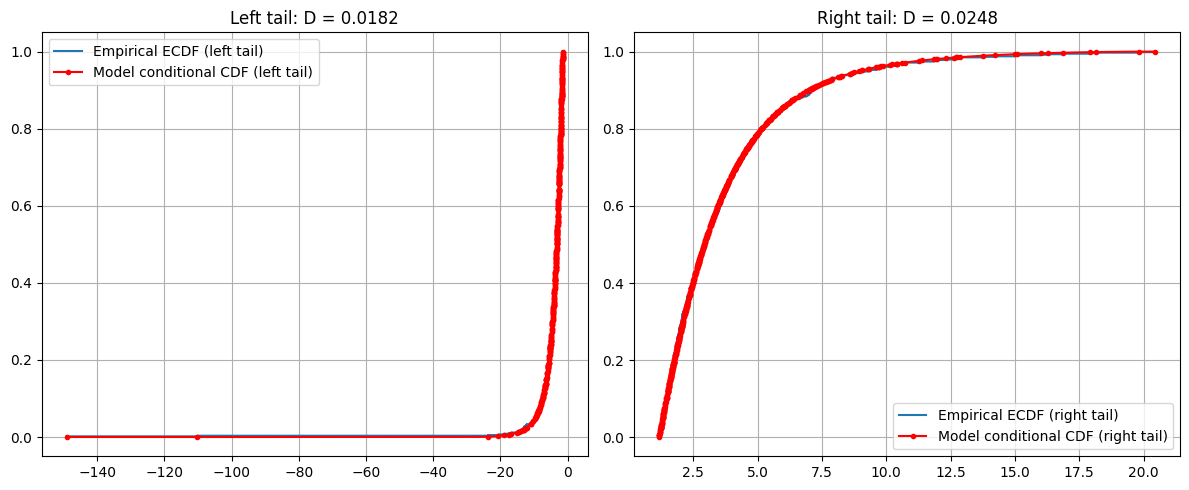

Running parallel bootstrap (B=500) for left tail ...
Left tail bootstrap p-value (Tail-KS) = 1.0000
Running parallel bootstrap (B=500) for right tail ...
Right tail bootstrap p-value (Tail-KS) = 0.9040


In [1]:
# tail_ks_fast.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, t
from scipy.interpolate import interp1d
from scipy import stats
from multiprocessing import Pool, cpu_count
import warnings
warnings.filterwarnings("ignore")

# ==========================================================
# Top: your data read & initial processing (already present)
# ==========================================================
df = pd.read_excel('TSLA1.xlsx')

# 确认列名（假设第二列是收盘价，可以打印 df.head() 查看实际列名）
print("数据前5行：")
print(df.head())

# 如果收盘价列叫 "Close"，用这个名字；否则替换成实际列名
if "Close" in df.columns:
    close_prices = df["Close"]
else:
    close_prices = df.iloc[:, 1]  # 退一步保险用第二列

# ==========================================================
#                          数据清洗
# ==========================================================
# 去掉 NaN 和 非正数
close_prices = close_prices.dropna()
close_prices = close_prices[close_prices > 0]

print("\n收盘价样本（前5个）：")
print(close_prices.head())
print("最小值:", close_prices.min())
print("是否有NaN:", close_prices.isna().any())
print("是否有非正数:", (close_prices <= 0).any())

# ==========================================================
#                       计算对数收益率
# ==========================================================
returns = 100 * np.log(close_prices / close_prices.shift(1))  # 对数收益率 ×100 变百分比
returns = returns.dropna()

print("\n收益率样本（前5个）：")
print(returns.head())

# ==========================================================
#                     收益率基本统计信息
# ==========================================================
print("\n收益率基本信息：")
print(returns.describe())

skewness = stats.skew(returns)
kurtosis_excess = stats.kurtosis(returns)
kurtosis = stats.kurtosis(returns, fisher=False)

print("偏度：", skewness)
print("超额峰度：", kurtosis_excess)
print("通常峰度：", kurtosis)

# -----------------------------
# 1. User configuration / parameters
# -----------------------------
THETA_LEFT = -1.4395        # 你的阈值（示例）
THETA_RIGHT = 1.171         # 你的阈值（示例）

# 模型参数（示例：替换为你的MLE估计值）
params = {
    "xi": 0.14786087346352017,
    "omega": 1.761869306368757,
    "alpha": -0.016032097147510645,
    "xi_t": -0.014085253434022872,
    "omega_t": 2.6869662613419854,
    "alpha_t": -0.03338510659470208,
    "nu": 3.2529685162075386,
    "theta1": THETA_LEFT,
    "theta2": THETA_RIGHT
}

# bootstrap 参数（可调）
BOOTSTRAP_N = 500    # 可改为 200 或 1000 根据需要
RNG_SEED = 12345

# -----------------------------
# 2. kernel PDFs (vectorized)
# -----------------------------
def skew_normal_pdf_vals(xs, xi, omega, alpha):
    z = (xs - xi) / omega
    return (2.0 / omega) * norm.pdf(z) * norm.cdf(alpha * z)

def skew_t_pdf_vals(xs, xi_t, omega_t, alpha_t, nu):
    z = (xs - xi_t) / omega_t
    t_pdf_z = t.pdf(z, df=nu)
    a_arr = alpha_t * z * np.sqrt((nu + 1) / (nu + z**2))
    t_cdf_a = t.cdf(a_arr, df=nu + 1)
    return (2.0 / omega_t) * t_pdf_z * t_cdf_a

# -----------------------------
# 3. Fast vectorized composite CDF grid builder
# -----------------------------
def build_composite_cdf_grid_fast(x_min, x_max, xi, omega, alpha,
                                 xi_t, omega_t, alpha_t, nu,
                                 theta1, theta2, n_grid=1200):
    """
    Fast vectorized construction of composite CDF using trapezoidal integration on a grid.
    Returns: interp_func, xs, cdf_vals, comp_pdf
    """
    xs = np.linspace(x_min, x_max, n_grid)
    dx = xs[1] - xs[0]

    # vectorized kernel pdfs on grid
    skewt_vals = skew_t_pdf_vals(xs, xi_t, omega_t, alpha_t, nu)
    skewnorm_vals = skew_normal_pdf_vals(xs, xi, omega, alpha)

    # cumulative trapezoid for kernel CDFs (approx)
    # We use cumulative trapezoid manually: cdf[i] = sum_{j< i} 0.5*(f_j + f_{j+1})*dx
    cdf_skewt = np.empty_like(xs)
    cdf_skewt[0] = 0.0
    cdf_skewt[1:] = np.cumsum(0.5 * (skewt_vals[:-1] + skewt_vals[1:]) * dx)

    cdf_skewn = np.empty_like(xs)
    cdf_skewn[0] = 0.0
    cdf_skewn[1:] = np.cumsum(0.5 * (skewnorm_vals[:-1] + skewnorm_vals[1:]) * dx)

    # get threshold-related quantities via interpolation
    theta1_c = np.clip(theta1, x_min, x_max)
    theta2_c = np.clip(theta2, x_min, x_max)
    S_t_theta1 = float(np.interp(theta1_c, xs, cdf_skewt))
    S_t_theta2 = float(np.interp(theta2_c, xs, cdf_skewt))
    S_n_theta1 = float(np.interp(theta1_c, xs, cdf_skewn))
    S_n_theta2 = float(np.interp(theta2_c, xs, cdf_skewn))

    s_t_theta1 = float(np.interp(theta1_c, xs, skewt_vals))
    s_t_theta2 = float(np.interp(theta2_c, xs, skewt_vals))
    s_n_theta1 = float(np.interp(theta1_c, xs, skewnorm_vals))
    s_n_theta2 = float(np.interp(theta2_c, xs, skewnorm_vals))

    # mixing weights r1, r2 (vector quantities are scalars here)
    numerator_r1 = s_t_theta2 * s_n_theta1 * S_t_theta1
    denominator_r1 = (s_t_theta1 * s_t_theta2 * (S_n_theta2 - S_n_theta1)
                      + s_t_theta2 * s_n_theta1 * S_t_theta1
                      + s_t_theta1 * s_n_theta2 * (1.0 - S_t_theta2))
    r1 = numerator_r1 / denominator_r1 if denominator_r1 != 0 else 0.0

    numerator_r2 = s_t_theta1 * (S_n_theta2 - S_n_theta1) + S_t_theta1 * s_n_theta1
    denominator_r2 = S_t_theta1 * s_n_theta1 if (S_t_theta1 * s_n_theta1) != 0 else 1.0
    r2 = 1.0 - r1 * (numerator_r2 / denominator_r2)

    # component masks on grid
    left_mask = xs <= theta1
    center_mask = (xs > theta1) & (xs < theta2)
    right_mask = xs >= theta2

    denom_left = S_t_theta1 if S_t_theta1 > 0 else 1e-12
    denom_center = (S_n_theta2 - S_n_theta1) if (S_n_theta2 - S_n_theta1) > 0 else 1e-12
    denom_right = (1.0 - S_t_theta2) if (1.0 - S_t_theta2) > 0 else 1e-12

    comp_pdf = np.empty_like(xs)
    comp_pdf[left_mask] = (r1 / denom_left) * skewt_vals[left_mask]
    comp_pdf[center_mask] = ((1.0 - r1 - r2) / denom_center) * skewnorm_vals[center_mask]
    comp_pdf[right_mask] = (r2 / denom_right) * skewt_vals[right_mask]

    # cumulative trapezoid for composite cdf
    cdf_vals = np.empty_like(xs)
    cdf_vals[0] = 0.0
    cdf_vals[1:] = np.cumsum(0.5 * (comp_pdf[:-1] + comp_pdf[1:]) * dx)
    # normalize numerically
    cdf_vals = np.clip(cdf_vals / cdf_vals[-1], 0.0, 1.0)

    interp_func = interp1d(xs, cdf_vals, kind='linear', bounds_error=False, fill_value=(0.0,1.0))
    return interp_func, xs, cdf_vals, comp_pdf

# -----------------------------
# 4. Tail-KS using conditional tail CDFs
# -----------------------------
def tail_ks_with_model(sample, model_cdf_interp, tail='right', theta=None, return_path=False):
    sample = np.asarray(sample)
    if tail == 'left':
        mask = sample <= theta
        sample_tail = np.sort(sample[mask])
        if sample_tail.size == 0:
            raise ValueError("No observations in left tail <= theta")
        n = len(sample_tail)
        ecdf = np.arange(1, n+1) / n
        F_theta = float(model_cdf_interp(theta))
        if F_theta <= 0:
            raise ValueError("Model F(theta) <= 0, cannot normalize left tail")
        model_vals = np.array([float(model_cdf_interp(x)) / F_theta for x in sample_tail])
        D_vals = np.abs(ecdf - model_vals)
        idx = int(np.argmax(D_vals))
        D = float(D_vals[idx])
        if return_path:
            return D, sample_tail[idx], idx, sample_tail, ecdf, model_vals
        else:
            return D, sample_tail[idx], idx

    elif tail == 'right':
        mask = sample >= theta
        sample_tail = np.sort(sample[mask])
        if sample_tail.size == 0:
            raise ValueError("No observations in right tail >= theta")
        n = len(sample_tail)
        ecdf = np.arange(1, n+1) / n
        F_theta = float(model_cdf_interp(theta))
        denom = 1.0 - F_theta
        if denom <= 0:
            raise ValueError("Model F(theta) >= 1, cannot normalize right tail")
        model_vals = np.array([(float(model_cdf_interp(x)) - F_theta) / denom for x in sample_tail])
        D_vals = np.abs(ecdf - model_vals)
        idx = int(np.argmax(D_vals))
        D = float(D_vals[idx])
        if return_path:
            return D, sample_tail[idx], idx, sample_tail, ecdf, model_vals
        else:
            return D, sample_tail[idx], idx
    else:
        raise ValueError("tail must be 'left' or 'right'")

# -----------------------------
# 5. Fast inversion sampling from grid CDF
# -----------------------------
def sample_from_model_grid(n, grid_xs, grid_cdf):
    eps = 1e-12
    gc = np.clip(grid_cdf, eps, 1-eps)
    inv_interp = interp1d(gc, grid_xs, bounds_error=False, fill_value=(grid_xs[0], grid_xs[-1]))
    u = np.random.rand(n)
    return inv_interp(u)

# -----------------------------
# 6. Parallel bootstrap for Tail-KS p-value
# -----------------------------
def _bootstrap_one(args):
    n, grid_xs, grid_cdf, tail, theta, model_cdf_interp = args
    sim = sample_from_model_grid(n, grid_xs, grid_cdf)
    if tail == 'left':
        sim_tail = np.sort(sim[sim <= theta])
        if len(sim_tail) < n:
            extra = sample_from_model_grid(n, grid_xs, grid_cdf)
            sim = np.concatenate([sim, extra])
            sim_tail = np.sort(sim[sim <= theta])[:n]
        else:
            sim_tail = sim_tail[:n]
        D_b, _, _ = tail_ks_with_model(sim_tail, model_cdf_interp, tail='left', theta=theta)
    else:
        sim_tail = np.sort(sim[sim >= theta])
        if len(sim_tail) < n:
            extra = sample_from_model_grid(n, grid_xs, grid_cdf)
            sim = np.concatenate([sim, extra])
            sim_tail = np.sort(sim[sim >= theta])[-n:]
        else:
            sim_tail = sim_tail[-n:]
        D_b, _, _ = tail_ks_with_model(sim_tail, model_cdf_interp, tail='right', theta=theta)
    return D_b

def tail_ks_bootstrap_pvalue_parallel(sample, model_cdf_interp, grid_xs, grid_cdf, tail, theta,
                                      B=500, rng_seed=None, n_jobs=None):
    np.random.seed(rng_seed)
    D_obs, _, _ = tail_ks_with_model(sample, model_cdf_interp, tail=tail, theta=theta)
    n = len(sample[(sample <= theta) if tail == 'left' else (sample >= theta)])
    if n <= 0:
        raise ValueError("No tail observations to bootstrap.")
    n_jobs = n_jobs or max(1, cpu_count() - 1)
    args_list = [(n, grid_xs, grid_cdf, tail, theta, model_cdf_interp) for _ in range(B)]
    with Pool(processes=n_jobs) as pool:
        D_boot_list = pool.map(_bootstrap_one, args_list)
    D_boot = np.array(D_boot_list)
    p_value = np.mean(D_boot >= D_obs)
    return D_obs, D_boot, p_value

# -----------------------------
# 7. Main workflow
# -----------------------------
def main():
    # use returns computed at top (pandas Series)
    returns_arr = returns.values
    print("Number of returns:", len(returns_arr))
    print("Basic stats (returns): mean {:.4f}, std {:.4f}".format(np.mean(returns_arr), np.std(returns_arr)))

    # build grid bounds
    x_min = np.percentile(returns_arr, 0.1) - 1.0
    x_max = np.percentile(returns_arr, 99.9) + 1.0
    print("Building composite CDF grid on [{:.3f}, {:.3f}] ...".format(x_min, x_max))

    interp_func, xs_grid, ys_grid, comp_pdf = build_composite_cdf_grid_fast(
        x_min, x_max,
        params["xi"], params["omega"], params["alpha"],
        params["xi_t"], params["omega_t"], params["alpha_t"], params["nu"],
        params["theta1"], params["theta2"],
        n_grid=1200
    )
    print("Grid built: {} points.".format(len(xs_grid)))

    # compute Tail-KS for left and right tails
    D_left, xmax_left, idx_left, sample_tail_left, ecdf_left, model_left = tail_ks_with_model(
        returns_arr, interp_func, tail='left', theta=params["theta1"], return_path=True)
    print("Left-tail KS D = {:.6f} at x = {:.4f} ({} tail obs)".format(D_left, xmax_left, len(sample_tail_left)))

    D_right, x_at_max_right, idx_right, sample_tail_right, ecdf_right, model_right = tail_ks_with_model(
        returns_arr, interp_func, tail='right', theta=params["theta2"], return_path=True)
    print("Right-tail KS D = {:.6f} at x = {:.4f} ({} tail obs)".format(D_right, x_at_max_right, len(sample_tail_right)))

    # plot ECDF vs model conditional CDF for tails
    fig, axes = plt.subplots(1,2, figsize=(12,5))
    axes[0].step(sample_tail_left, ecdf_left, where='post', label='Empirical ECDF (left tail)')
    axes[0].plot(sample_tail_left, model_left, 'r.-', label='Model conditional CDF (left tail)')
    axes[0].set_title("Left tail: D = {:.4f}".format(D_left))
    axes[0].legend()
    axes[0].grid(True)

    axes[1].step(sample_tail_right, ecdf_right, where='post', label='Empirical ECDF (right tail)')
    axes[1].plot(sample_tail_right, model_right, 'r.-', label='Model conditional CDF (right tail)')
    axes[1].set_title("Right tail: D = {:.4f}".format(D_right))
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    # bootstrap p-values (parallel)
    print("Running parallel bootstrap (B={}) for left tail ...".format(BOOTSTRAP_N))
    Dleft_obs, Dleft_boot, pleft = tail_ks_bootstrap_pvalue_parallel(
        returns_arr, interp_func, xs_grid, ys_grid, tail='left', theta=params["theta1"],
        B=BOOTSTRAP_N, rng_seed=RNG_SEED, n_jobs=None)
    print("Left tail bootstrap p-value (Tail-KS) = {:.4f}".format(pleft))

    print("Running parallel bootstrap (B={}) for right tail ...".format(BOOTSTRAP_N))
    Dright_obs, Dright_boot, pright = tail_ks_bootstrap_pvalue_parallel(
        returns_arr, interp_func, xs_grid, ys_grid, tail='right', theta=params["theta2"],
        B=BOOTSTRAP_N, rng_seed=RNG_SEED+1, n_jobs=None)
    print("Right tail bootstrap p-value (Tail-KS) = {:.4f}".format(pright))

    # optionally save results
    # np.savez("tailks_results_fast.npz", D_left=D_left, D_right=D_right, Dleft_boot=Dleft_boot, Dright_boot=Dright_boot)

if __name__ == "__main__":
    main()
